In [1]:
%load_ext version_information

In [2]:
import datetime
from pprint import pprint

import spacepy.plot as spp
import path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from spacepy import omni
from spacepy import time as spt
from spacepy import plot as spp
spp.revert_style()
import seaborn as sns
sns.set(font_scale=1.5)
sns.set_style("whitegrid")
import tqdm
from scipy import stats
import matplotlib
from sklearn.neighbors import KDTree
from spacepy import omni as omni
from spacepy import toolbox as tb
from spacepy import time as spt
from spacepy import datamodel as dm
import scipy
import h5py

import verify

%version_information numpy, matplotlib, version_information, verify, scipy, sklearn, seaborn, spacepy, h5py

This unreleased version of SpacePy is not supported by the SpacePy team.


/Users/balarsen/miniconda3/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


Software,Version
Python,3.6.6 64bit [GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
IPython,7.1.1
OS,Darwin 17.7.0 x86_64 i386 64bit
numpy,1.15.4
matplotlib,3.0.1
version_information,1.0.3
verify,The 'verify' distribution was not found and is required by the application
scipy,1.1.0
sklearn,0.20.0
seaborn,0.9.0


# Load the CXD data and look for a probability distribution

In [3]:
df = pd.read_hdf('../Data/CXD_Data.h5', 'Log_Flux_1.6_std')

In [4]:
df.head()

2001-02-20 08:00:00    0.471567
2001-02-20 16:00:00    0.254677
2001-02-21 00:00:00   -0.041419
2001-02-21 08:00:00    0.204187
2001-02-21 16:00:00    0.187263
Name: Log_Flux_1.6_std, dtype: float64

Text(0, 0.5, 'Log_Flux_1.6_std')

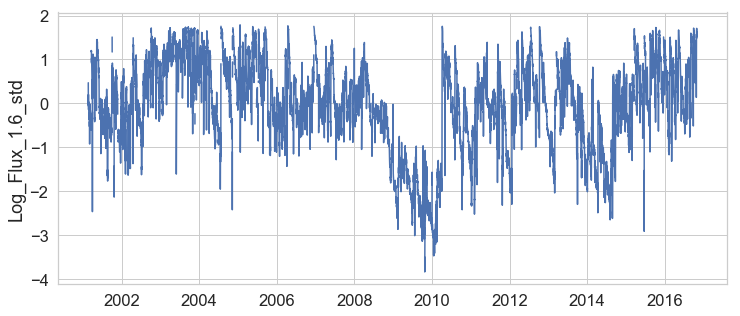

In [5]:
df.plot(figsize=(12,5))
plt.ylabel('Log_Flux_1.6_std')

Text(0, 0.5, 'Probability density')

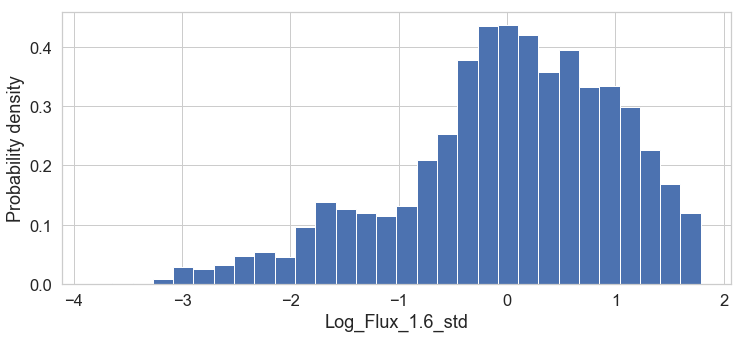

In [8]:
df.hist(bins=30, density=True, figsize=(12,5))
plt.xlabel('Log_Flux_1.6_std')
plt.ylabel('Probability density')

Text(0, 0.5, 'Probability density')

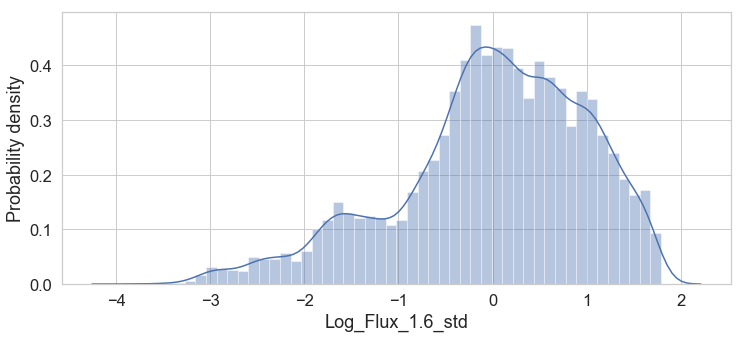

In [11]:
plt.figure(figsize=(12,5))
sns.distplot(df.dropna().values)
plt.xlabel('Log_Flux_1.6_std')
plt.ylabel('Probability density')

In [13]:
gamma_fit_p = stats.gamma.fit(df.dropna().values)
gamma_fit_p

(280.3511666395906, -17.376984139480733, 0.06200862771961621)

/Users/balarsen/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


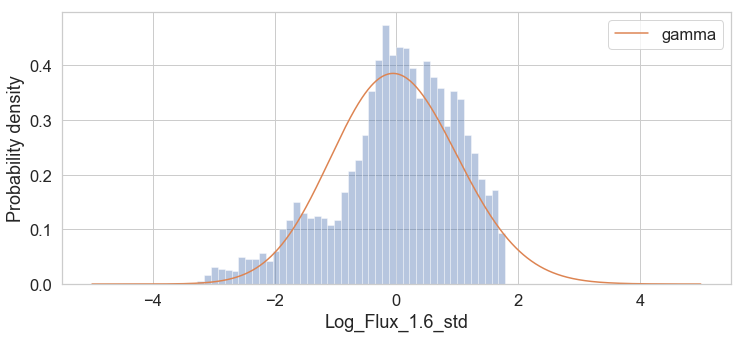

In [16]:
X = np.linspace(-5, 5, 1000)
Y = stats.gamma(*gamma_fit_p).pdf(X)
plt.figure(figsize=(12,5))
sns.distplot(df.dropna().values, norm_hist=True, kde=False)
plt.xlabel('Log_Flux_1.6_std')
plt.ylabel('Probability density')

plt.plot(X, Y, label='gamma')
plt.legend()